# Analyzing the Reflected Light of a Tesla Car in Space

In Feb. 6, [SpaceX](https://en.wikipedia.org/wiki/SpaceX) [launched](https://www.nasaspaceflight.com/2018/02/falcon-heavy-success-paves-space-beyond-earth/#more-54876) [Falcon Heavy](https://en.wikipedia.org/wiki/Falcon_Heavy), the most powerful rocket in operation as of 2018. The rocket's payload is Elon Musk's famed Tesla Roadster with a dummy driver called Starman released in space zipping towards Mars's direction. 

![credit: SpaceX](figures/starman.gif)

In Feb. 10, Erik Dennihy and JJ Hermes used the 4.1-meter [SOAR telescope](https://en.wikipedia.org/wiki/Southern_Astrophysical_Research_Telescope) in CTIO, Chile to monitor its brightness for about 1 hour. JJ Hermes posted a [tweet](https://twitter.com/jotajotahermes/status/962545252446932993?ref_src=twcamp%5Eshare%7Ctwsrc%5Eios%7Ctwgr%5Ejp.naver.line.Share%7Ctwcon%5E7100%7Ctwterm%5E0) showing the light curve (brightness of object as function of time) of Starman. A video of the actual footage is [here](https://twitter.com/jotajotahermes/status/962545718622937088).

![credit: Erik Dennihy @ UNC](figures/roadster_lc.jpg)

![image](figures/starman2.jpg)

Hanno Rein et al. also posted a hilarious at first but insightful paper in ArXiv entitled [The random walk of cars and their collision probabilities with planets](https://arxiv.org/abs/1802.04718). In this study, they ran N-body simulations using a large ensemble of simulations with slightly perturbed initial conditions, and estimated the probability of a collision of the Tesla roadster with Earth and Venus over the next one million years to be 6% and 2.5%, respectively. Cool right? 

But anyway, in this post, we aim to confirm whether the Tesla Roadster (a.k.a. Starman, 2018-017A) is indeed rotating with a period of 4.7589 +/- 0.0060 minutes.

First, let's download data from [here](http://k2wd.org/share/roadster.dat) directly using pandas. The first column is time in seconds, and the second column in relative flux (or brightness of object per unit area).

In [1]:
import pandas as pd

link = 'http://k2wd.org/share/roadster.dat'
data = pd.read_csv(link, delimiter=' ', comment='#')
data.columns = ['Time','Flux']

* inspect data

In [2]:
data.head()

,Time,Flux
0,15.881,0.07878
1,31.706,0.18612
2,47.564,0.10497
3,63.405,0.07927
4,79.261,0.05045


From the data above, we can see that each measurement was taken in every 15 seconds. 

In [3]:
%matplotlib inline

#styling
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

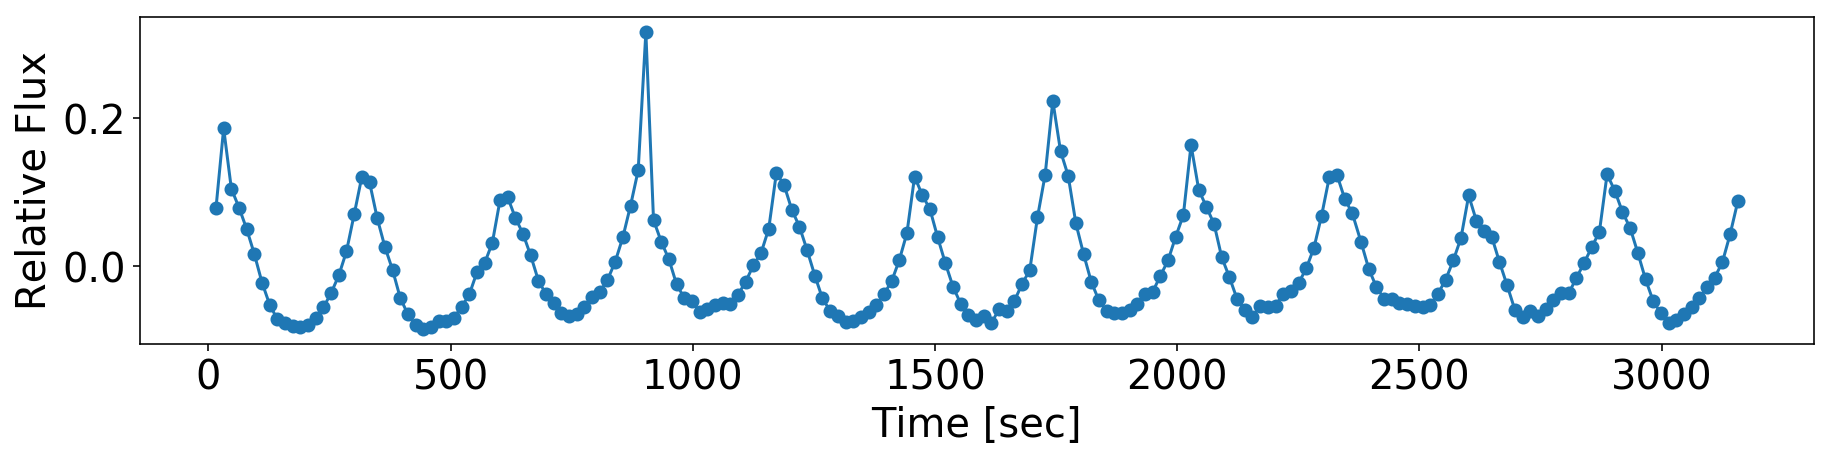

In [4]:
import matplotlib.pyplot as pl

t=data.Time
f=data.Flux

fig,ax = pl.subplots(1,1,figsize=(15,3))
ax.plot(t,f,'o-')
ax.set(xlabel='Time [sec]',
       ylabel='Relative Flux');

## Finding period

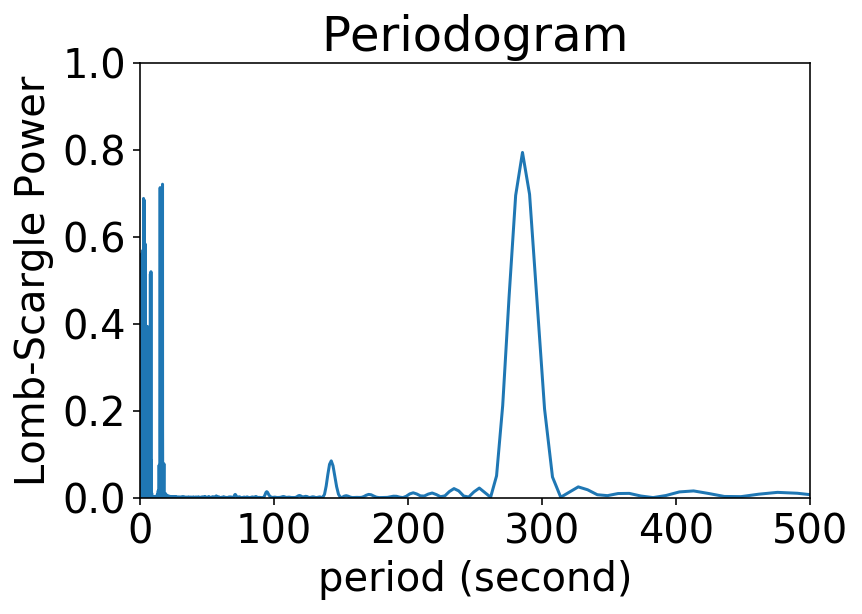

In [6]:
from gatspy.periodic import LombScargleFast

model = LombScargleFast().fit(t, f)
periods, power = model.periodogram_auto(nyquist_factor=100)

fig, ax = pl.subplots()
ax.plot(periods, power)
ax.set(xlim=(0, 500), ylim=(0, 1),
       xlabel='period (second)',
       ylabel='Lomb-Scargle Power',
       title='Periodogram');

The highest peak of the periodogram corresponds to optimum period.

In [7]:
import numpy as np

idx=np.argmax(power)

period in seconds

In [8]:
p=periods[idx]
p

285.58900000000006

period in minutes

In [9]:
p/60

4.7598166666666675

In [10]:
model.optimizer.period_range=(250, 300)
period = model.best_period
print("period = {0}".format(period))

Finding optimal frequency:
 - Estimated peak width = 0.002
 - Using 5 steps per peak; omega_step = 0.0004
 - User-specified period range:  2.5e+02 to 3e+02
 - Computing periods at 12 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
period = 285.6514105051437


## Phase-folding

Let's fold the light curve and see how much the brightness varies during each period

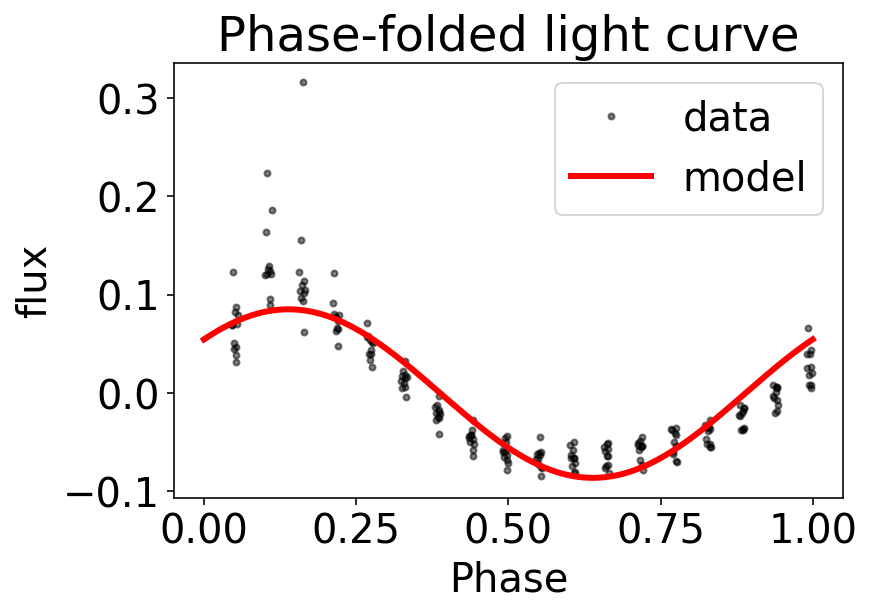

In [11]:
phase = (t / period) % 1

# Compute best-fit template

phase_fit = np.linspace(0, 1, 1000)
f_fit = model.predict(period * phase_fit, period=period)

# Plot the phased data & model
fig, ax = pl.subplots()
ax.plot(phase, f, '.k', alpha=0.5, label='data')
ax.plot(phase_fit, f_fit, '-r', lw=3, label='model')
ax.set(xlabel='Phase', 
       ylabel='flux',
      title='Phase-folded light curve');
ax.legend()

In [12]:
def simple_sine(theta, t):
    a, b, c = theta
    return a * np.sin(b * t + c)

def lnlike(params, t, f):    
    m = simple_sine(params[:3], t)
    sig = params[3]
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    #prior
    if np.any(theta < 0):
        return -np.inf
    
    #loglike
    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf

nlp = lambda *args: -lnprob(*args)

In [13]:
import scipy.optimize as op

init_guess = (0.1,6,0.1,0.1) #amplitude, phase, lag, uncertainty in flux
args = (phase, f)

opt = op.minimize(nlp, init_guess, args=args, method='nelder-mead')
print(opt.success)

True


In [14]:
for i in opt.x:
    print ("parameter optimum: {}".format(i))

parameter optimum: 0.08743207395833993
parameter optimum: 5.715844648237095
parameter optimum: 1.0096642965621723
parameter optimum: 0.02909406657640007


Plot optimized fit

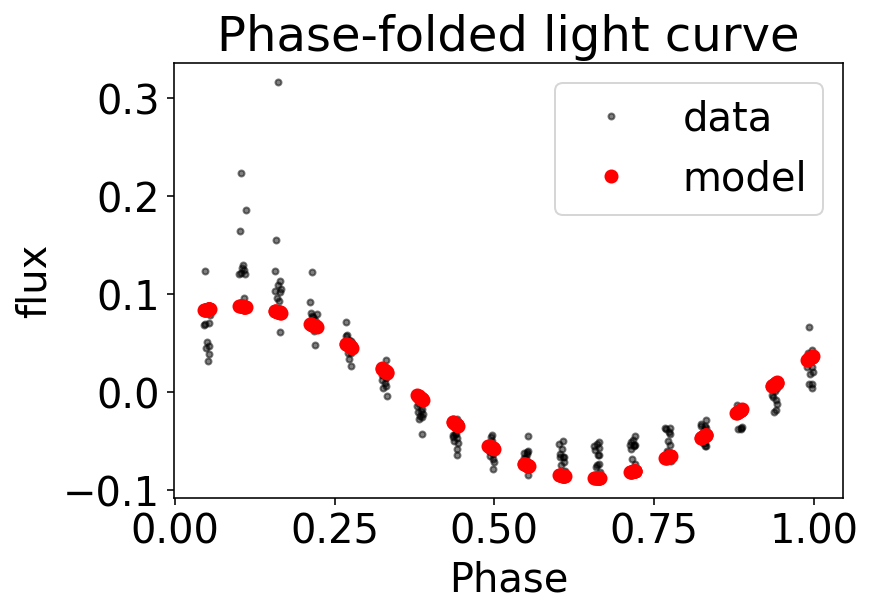

In [17]:
# Plot the phased data & model
fig, ax = pl.subplots()

ax.plot(phase, f, '.k', alpha=0.5, label='data')
ax.plot(phase, simple_sine(opt.x[:3], phase), 'ro', lw=3, label='model')
ax.set(xlabel='Phase', 
       ylabel='flux',
      title='Phase-folded light curve');
ax.legend()

In [19]:
h = lambda x,a,b,c: a*np.sin(b*x+c) 

p_opt, p_cov = op.curve_fit(h, phase, f, p0=init_guess[:3])
var = np.diag(p_cov)
std = np.sqrt(np.diag(p_cov)) #a.k.a. sigma

for i,j in zip(p_opt, std):
    print ("parameter optimum: {} +/- {}".format(i, j))

parameter optimum: 0.08743120418068444 +/- 0.0029704418459843653
parameter optimum: 5.7157960215984565 +/- 0.12098078217792571
parameter optimum: 1.0097107341855762 +/- 0.08059871454310832


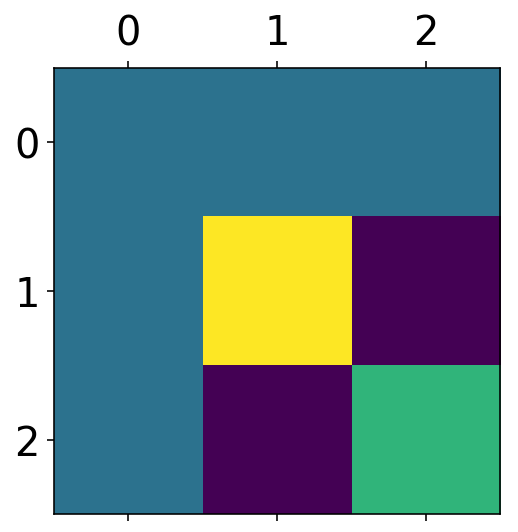

In [20]:
pl.matshow(p_cov)

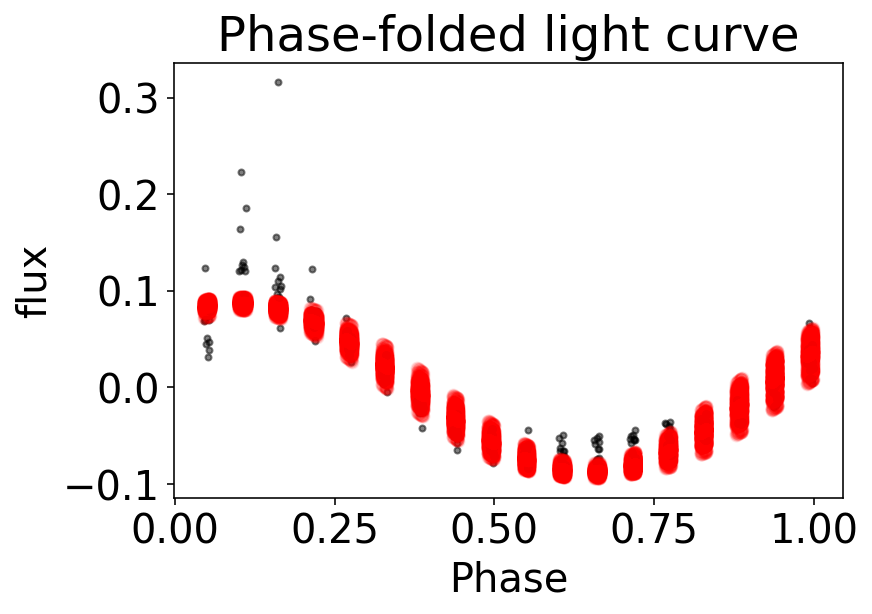

In [21]:
# Plot the phased data & model
fig, ax = pl.subplots()

ax.plot(phase, f, '.k', alpha=0.5, label='data')
ax.plot(phase, h(phase, *p_opt), 'ro', lw=3, label='model')

for i in range(100):
    theta = p_opt + np.random.randn(p_opt.size) * std
    pl.plot(phase, h(phase, *theta),'ro', lw=3, alpha=0.1)
    
ax.set(xlabel='Phase', 
       ylabel='flux',
      title='Phase-folded light curve');
#ax.legend()

In [116]:
from emcee import EnsembleSampler
from emcee.utils import sample_ball
from tqdm import tqdm

# initial = opt.x

ndim = len(init_guess)
nwalkers = 8 * ndim
nsteps1 = 500
nsteps2 = 3000

sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=args, threads=1)
pos0 = sample_ball(init_guess, [1e-1]*ndim, nwalkers)

width = 30
print("\nstage 1")
for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

2it [00:00, 19.16it/s]


stage 1


500it [00:14, 33.72it/s]


In [117]:
print("\nstage 2")
idx = np.argmax(sampler.lnprobability)
best = sampler.flatchain[idx]
pos0 = sample_ball(best, [1e-5]*ndim, nwalkers)
sampler.reset()

for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps2)):
    pass

2it [00:00, 19.54it/s]


stage 2


3000it [03:25, 21.68it/s]


In [138]:
chain = sampler.chain
labels = ['${}$'.format(i) for i in r'A,\theta,\phi,\sigma'.split(',')]

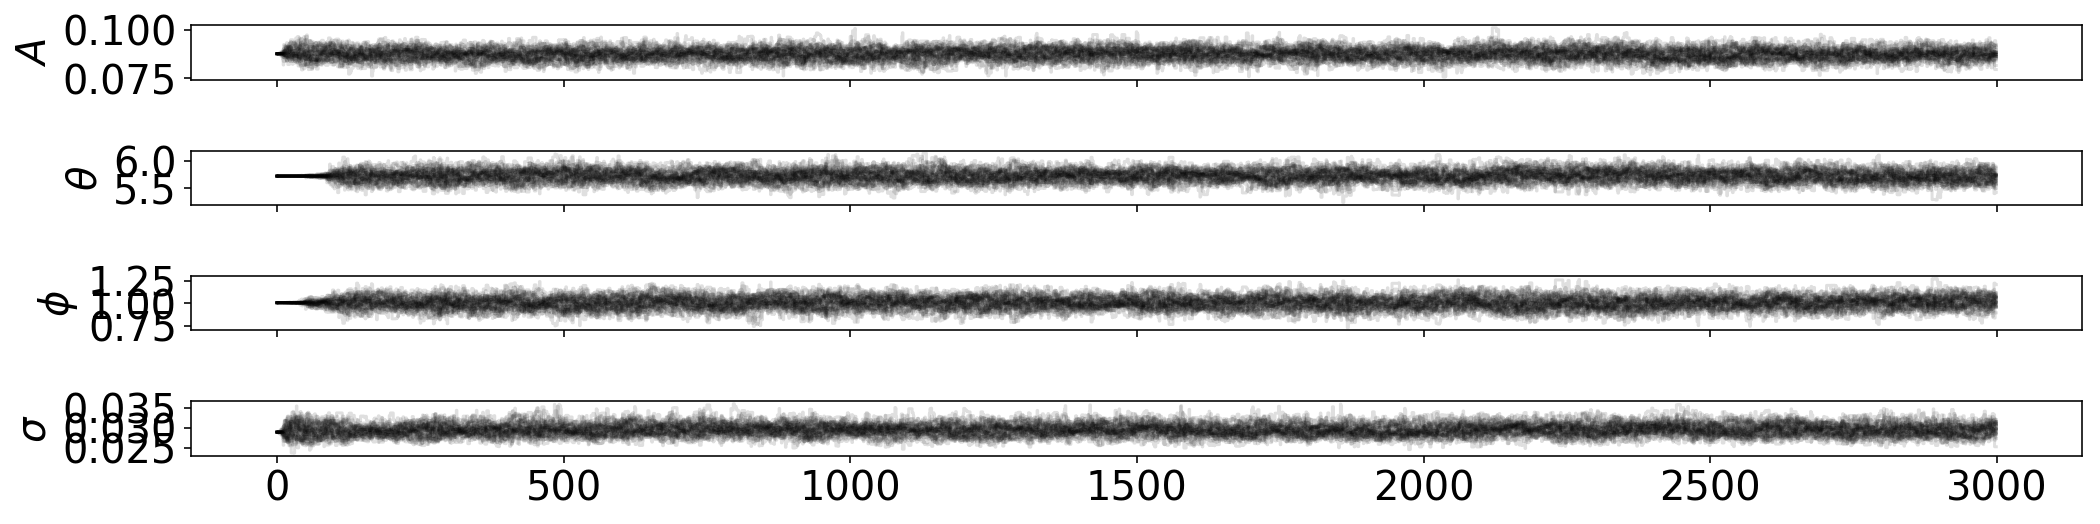

In [140]:
fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim), sharex=True)
[axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
[ax.set_ylabel(labels[i], fontsize=20) for i,ax in enumerate(axs)]
fig.tight_layout()

In [123]:
chain.shape

(32, 3000, 4)

In [124]:
fc = np.reshape(chain,(-1,ndim))

Measure autocorrelation needed to ensure independent sampling (as procy for convergence).

In [131]:
from acor import acor

taus = []
for i in range(ndim):
    j = fc[:,i]
    tau,_,_ =acor(j)
    tau = int(round(tau))
    taus.append(tau)
    print('tau={}\t ndata={}'.format(tau,len(j[::tau])))

tau=61	 ndata=1574
tau=53	 ndata=1812
tau=53	 ndata=1812
tau=51	 ndata=1883


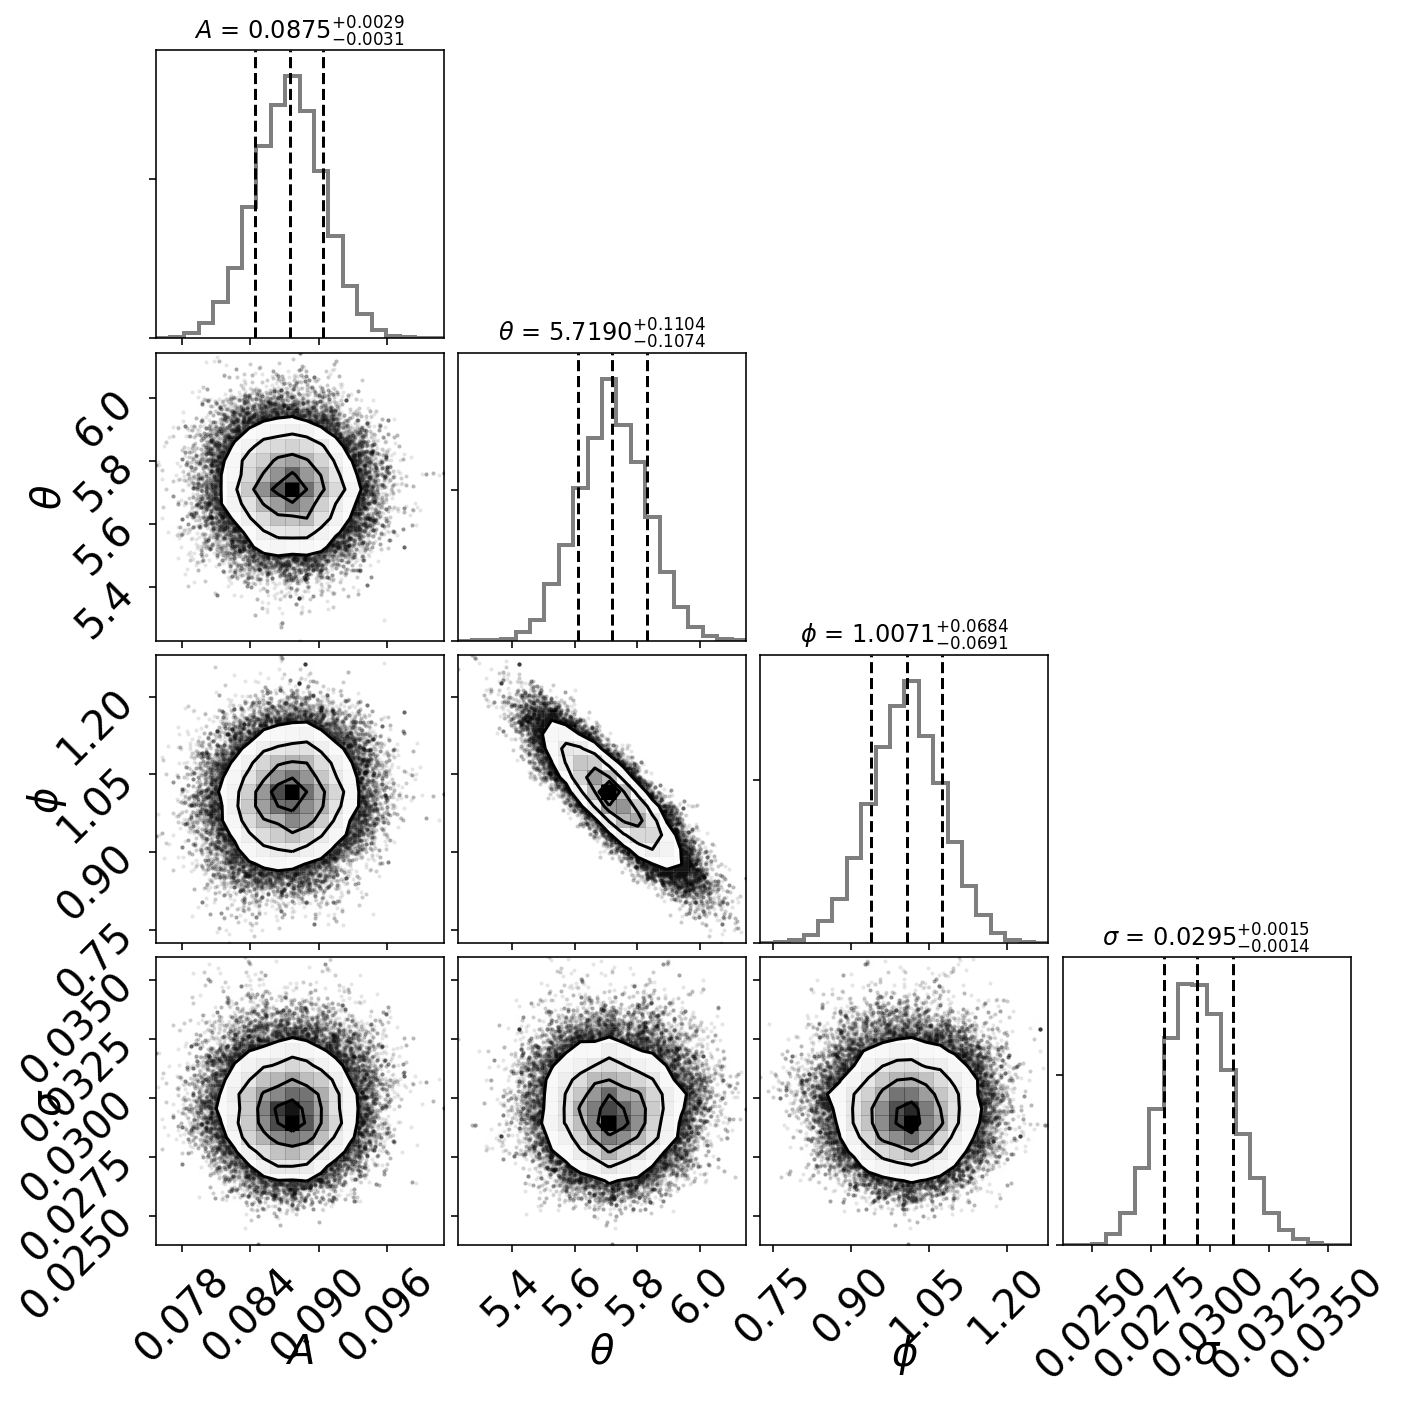

In [142]:
from corner import corner

hist_kwargs = dict(lw=2, alpha=0.5)
title_kwargs = dict(fontdict=dict(fontsize=12))

fig = pl.figure(figsize=(8,8))

corner(fc, labels=labels, #truths=truths,
       hist_kwargs=hist_kwargs,
       title_kwargs=title_kwargs,
       show_titles=True, 
       quantiles=[0.16,0.5,0.84],
       title_fmt='.4f');
#     fig.tight_layout()

In [154]:
df=pd.DataFrame(fc)
df.columns = ['A','theta','phi','sigma']

In [155]:
df.describe()

,A,theta,phi,sigma
count,96000.000000,96000.000000,96000.000000,96000.000000
mean,0.087417,5.720586,1.006708,0.029509
std,0.003017,0.109209,0.069442,0.001492
min,0.075645,5.229286,0.724756,0.023744
25%,0.085370,5.647212,0.960598,0.028476
50%,0.087472,5.719009,1.007123,0.029456
75%,0.089431,5.793956,1.053540,0.030490
max,0.101007,6.145158,1.280248,0.035980


In [143]:
def get_stats(sample,tol=4):
    '''
    return 50th, 16th, and 84th percentiles
    (median & 1 sigma limits) of a given sample
    '''
    l,m,r = np.percentile(sample,[16,50,84])

    return m, m-l, r-m

In [153]:
vals, uncs = [], []

for i in range(ndim):
    j=fc[:,i][taus[i]]
    d=get_stats(j)
    vals.append(d[0])
    uncs.append((d[1],d[2]))
    print('{:.3f} +{:.3f} -{:.3f}'.format((d[0]),d[1],d[2]))

0.084 +0.000 -0.000
5.721 +0.000 -0.000
1.019 +0.000 -0.000
0.030 +0.000 -0.000


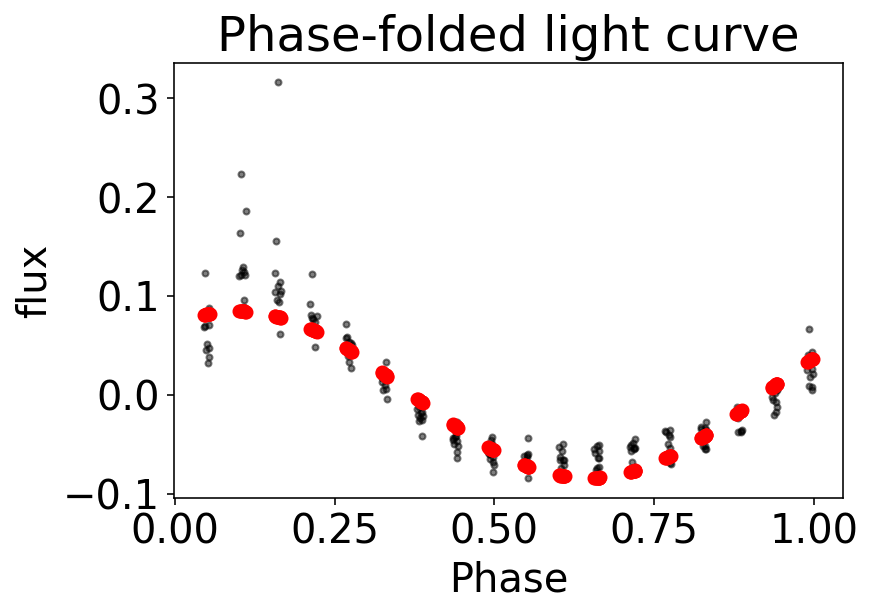

In [159]:
# Plot the phased data & model
fig, ax = pl.subplots()

ax.plot(phase, f, '.k', alpha=0.5, label='data')
ax.plot(phase, h(phase, *vals[:3]), 'ro', lw=3, label='model')
    
ax.set(xlabel='Phase', 
       ylabel='flux',
      title='Phase-folded light curve');
#ax.legend()